In [5]:
%matplotlib inline

from memsql.common import connection_pool
from scipy import stats
import sys, signal, argparse
import matplotlib
import matplotlib.pyplot as plt

### Define your connection variables for MemSQL here

In [6]:
DB_HOST = "x.memcompute.com"
DB_PORT = 3306
DB_USER = "root"
DB_PASS = None
DB_NAME = "stocks"

pool = connection_pool.ConnectionPool()
db_args = [DB_HOST, DB_PORT, DB_USER, DB_PASS, DB_NAME]

### Other properties

In [7]:
TICKERS = [
    'BLAH', 'DUH', 'UM', 'UHH', 'ERR',
    'WUT', 'LOL', 'DERP', 'UP', 'DOWN'
]

### Plot the stocks from the database

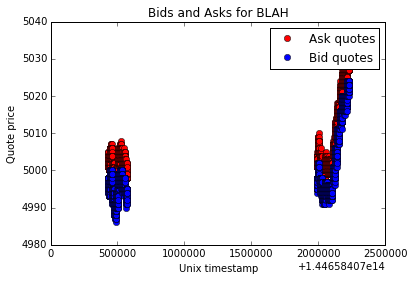

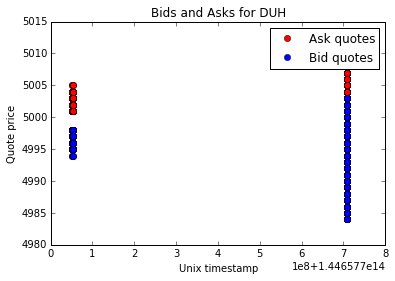

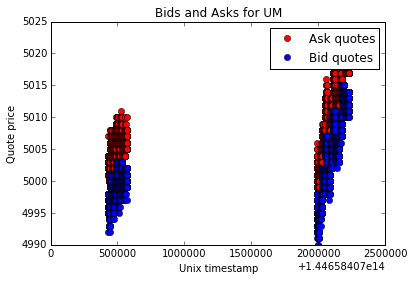

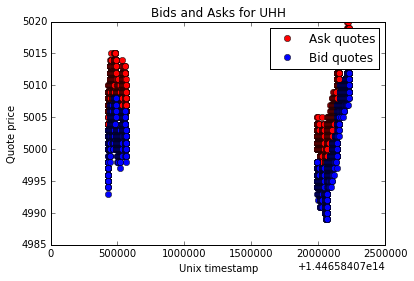

In [ ]:
for ticker in TICKERS:
    with pool.connect(*db_args) as c:
        asks_query = "SELECT * FROM ask_quotes WHERE ticker='%s';" % ticker
        bids_query = "SELECT * FROM bid_quotes WHERE ticker='%s';" % ticker

        a = c.query(asks_query)
        tsa = [getattr(i, 'ts') for i in a]
        apa = [getattr(i, 'ask_price') for i in a]

        b = c.query(bids_query)
        tsb = [getattr(i, 'ts') for i in b]
        apb = [getattr(i, 'bid_price') for i in b]

        plt.plot(tsa, apa, 'ro', label='Ask quotes')
        plt.plot(tsb, apb, 'bo', label='Bid quotes')
        plt.title('Bids and Asks for %s' % ticker)
        plt.ylabel("Quote price")
        plt.xlabel("Unix timestamp")
        plt.legend(numpoints=1)

        plt.show()